МІНІСТЕРСТВО ОСВІТИ І НАУКИ, МОЛОДІ ТА СПОРТУ УКРАЇНИ
НАЦІОНАЛЬНИЙ ТЕХНІЧНИЙ УНІВЕРСИТЕТ УКРАЇНИ
«КИЇВСЬКИЙ ПОЛІТИХНІЧНИЙ ІНСТИТУТ ІМ.ІГОРЯ СІКОРСЬКОГО»
ФІЗИКО-ТЕХНІЧНИЙ ІНСТИТУТ


Лабораторна робота №6
«Цифрова стеганографія засобами найменш значущого біта»
Варіант 9





Виконав:                                                                     Студент 2 курсу
     Групи ФІ-21
Климентьєв Максим




Київ 2024

1. Ознайомитись із усіма теоретичними відомостями до лабораторної роботи.
2. Виконати проєктування програмного додатку для PC, який:

    1. виконує вбудовування водяного знаку зображення. Для процесу вбудовування водяний знак перетворити до бінарного (чорно-білого, не сірого!). Використати для вбудовування метод найменшого значущого біта. Параметр «номер бітової площини» (натуральне число, менше за 9) вивести на форму головного вікна для відображення різниці в результатах вбудовування. Водяний знак вбудовувати у канал Blue. Передбачити випадок різних розмірів вхідного зображення (контейнера) та водяного знаку. Якщо вхідне зображення більше за водяний знак, виконати вбудовування циклічно та періодично для всього вхідного зображення (замостити вхідне зображення водяним знаком). Якщо вхідне зображення менше за водяний знак, вбудувати частину водяного знаку для всього вхідного зображення. 

    2. Здійснити вбудовування текстової інформації (яка представлена побітово) у вхідне зображення на основі методу найменшого значущого біта. 
    
    3. Додатковий бал передбачається з встворення методу, який виконує вилучення вонядного знаку із заповненого конейнега (зображення з водяним знаком) для завдання 7 даної лабораторної роботи.
3. Усі пункти завдання лабораторної роботи виконати в одному багатовіконному програмному додатку.
4. Навести основні етапи проєктування додатку, зокрема, вказати діаграму класів, діаграму пакетів та діаграму прецедентів користування додатком.
5. Відповіді на контольні запитання не потрібно додавати до звіту.

In [1]:
from PIL import Image as Im
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Sg:
    def __init__(self, img_path, wm_path):
        self.img = Im.open(img_path)
        self.wm = Im.open(wm_path)
        # self.img_g = Im.Image.convert(self.img, "L")
        self.wm_g = Im.Image.convert(self.wm, "L")
        self.resize_wm()
        self.create_bin_mask()

    def resize_wm(self):
        col, row = self.img.size
        wm_array = np.array(self.wm)
        
        while wm_array.shape[0] < row or wm_array.shape[1] < col:
            wm_array = np.concatenate((wm_array, wm_array), axis=1)
            wm_array = np.concatenate((wm_array, wm_array), axis=0)
        
        self.wm = Im.fromarray(wm_array[:row, :col])
        self.wm_g = Im.fromarray(wm_array[:row, :col]).convert("L")
        return wm_array

    def create_bin_mask(self):
        wm_array = np.array(self.wm_g, dtype=np.double)

        wm_array = ((wm_array - np.min(np.min(wm_array))) / (np.max(np.max(wm_array)) - np.min(np.min(wm_array)))) * 255
        wm_array[wm_array > 127] = 255
        wm_array[wm_array <= 127] = 0

        self.bin_mask_array = wm_array
        return wm_array

    def apply_mask_for_bit_and_color(self, bit=0, color=0, array=None):
        self.bit_used = bit
        self.color_used = color
        self._check_color_and_bit(color, bit)

        
        img_array = np.array(self.img)

        color_array = img_array[:, :, color]
        
        img_fragment = np.unpackbits(color_array[:, :, np.newaxis], axis=2, bitorder="little")
        if array is None:
            img_fragment[:, :, bit] = np.logical_xor(img_fragment[:, :, bit], self.bin_mask_array)
        else:
            img_fragment[:, :, bit] = np.logical_xor(img_fragment[:, :, bit], array)
        img_fragment = np.packbits(img_fragment, axis=2, bitorder="little")

        img_fragment = img_fragment[:, :].reshape(img_fragment.shape[0], img_fragment.shape[1])

        img_array[:, :, color] = img_fragment
        self.img_wm = img_array
        return img_array
    
    def extract_watermark(self, bit=-1, color=-1):
        self._check_color_and_bit(color, bit)
        if bit == -1 and color == -1:
            color_array = self.img_wm[:, :, self.color_used]
            
            img_fragment = np.unpackbits(color_array[:, :, np.newaxis], axis=2, bitorder="little")
            img_fragment[:, :, self.bit_used] = np.logical_xor(img_fragment[:, :, self.bit_used], self.bin_mask_array)
            img_fragment = np.packbits(img_fragment, axis=2, bitorder="little")

            img_fragment = img_fragment[:, :].reshape(img_fragment.shape[0], img_fragment.shape[1])

            self.img_wm[:, :, self.color_used] = img_fragment
            return self.show_specified_bit_for_color(array=self.img_wm)
        else:
            img_array = np.array(self.img)
            color_array = self.img_wm[:, :, color]
            
            img_fragment = np.unpackbits(color_array[:, :, np.newaxis], axis=2, bitorder="little")
            img_fragment[:, :, bit] = np.logical_xor(img_fragment[:, :, bit], self.bin_mask_array)
            img_fragment = np.packbits(img_fragment, axis=2, bitorder="little")

            img_fragment = img_fragment[:, :].reshape(img_fragment.shape[0], img_fragment.shape[1])

            self.img_wm = img_array
            self.img_wm[:, :, color] = img_fragment
            return self.show_specified_bit_for_color(array=self.img_wm)
        
    def _check_color_and_bit(self, color: int=0, bit: int=0):
        if color > 2:
            raise Exception("Color number must be 0, 1 or 2")
        if bit > 7:
            raise Exception("Bit number must be 0, 1, 2, 3, 4, 5, 6 or 7")

    def data_to_bin(self, data):
        if isinstance(data, str):
            return ''.join([ format(ord(i), "08b") for i in data ])
        elif isinstance(data, bytes):
            return ''.join([ format(i, "08b") for i in data ])
        elif isinstance(data, np.ndarray):
            return [ format(i, "08b") for i in data ]
        elif isinstance(data, int) or isinstance(data, np.uint8):
            return format(data, "08b")
        else:
            raise TypeError("Type not supported.")

    
    def encode(self, secret_data, path="lab6/EncodedImage.png", sign=1):
        image = np.array(self.img)
        max_bytes = image.shape[0] * image.shape[1] * image.shape[2] // 8
        if len(secret_data) > max_bytes:
            raise ValueError("Insufficient bytes, need bigger image or less data.")
        secret_data += "====="
        data_index = 0
        binary_secret_data = self.data_to_bin(secret_data)
        data_len = len(binary_secret_data)
        for row in image:
            for pixel in row:
                r, g, b = self.data_to_bin(pixel)
                if data_index < data_len:
                    pixel[0] = int(r[:-1] + sign * binary_secret_data[data_index], 2)
                    data_index += 1
                if data_index < data_len:
                    pixel[1] = int(g[:-1] + sign * binary_secret_data[data_index], 2)
                    data_index += 1
                if data_index < data_len:
                    pixel[2] = int(b[:-1] + sign * binary_secret_data[data_index], 2)
                    data_index += 1
                if data_index >= data_len:
                    break
        self.img = Im.fromarray(image)
        self.img.save(path)
        return image

    def decode(self):
        image = np.array(self.img)
        binary_data = ""
        for row in image:
            for pixel in row:
                r, g, b = self.data_to_bin(pixel)
                binary_data += r[-1]
                binary_data += g[-1]
                binary_data += b[-1]
        all_bytes = [binary_data[i: i+8] for i in range(0, len(binary_data), 8)]
        
        decoded_data = ""
        for byte in all_bytes:
            decoded_data += chr(int(byte, 2))
            if decoded_data[-5:] == "=====":
                break
        return decoded_data[:-5]
    
    def show(self, bit: int=-1, color: int=-1, show_all_for_color: bool=False):
        if bit == -1 and color == -1:
            fig, ax = plt.subplots()
            ax.imshow(self.img)
        else:
            self._check_color_and_bit(color, bit)
            if show_all_for_color:
                return self.show_for_all_bits_for_color(color)
            else:
                return self.show_specified_bit_for_color(bit, color)

    def show_specified_bit_for_color(self, bit: int=0, color: int=0, array=None):
        self._check_color_and_bit(color, bit)

        fig, ax = plt.subplots()
        if array is not None:
            img_r = Im.fromarray(array)
        else:
            img_r = Im.fromarray(self.apply_mask_for_bit_and_color(bit, color))
        ax.imshow(img_r)

    def show_for_all_bits_for_color(self, color: int=0, array=None):
        self._check_color_and_bit(color)

        fig, axes = plt.subplots(2, 4) # , figsize=(15, 15)
        for p in range(8):
            if array is not None:
                img_r = Im.fromarray(array)
            else:
                img_r = Im.fromarray(self.apply_mask_for_bit_and_color(p, color))
            if p < 4:
                axes[0, p].imshow(img_r)
            else:
                axes[1, p - 4].imshow(img_r)

Decoded data: This is a top secret message.1
Ù ÅáîqÛu·$¶ÓnÆÜ2~¶¥ssJqÆù7S&²I$² p qp` ªöõbvØÎtàqÇñÅø@ðãPÇÊùÿ 7?=eCô¦1PþõSÞÛl¬ÂóNþ!&}¨ÑTÅØã¬`Â²Ô®#$§/Fã[!&åjÛò`ÒxàËnü øð?P£Ë& ~Fìl< u;bN#~¬-6{üá·<CàN?àñ@	R­ ;7Ê^Ýª'+;¹$iÍmÉ·ûIÔ°hKaÆ*ÝÆÀü 8ÿÿà¿àÏÆZo »?ámÉßÊÓªíj¨æ8òöÄ=#lÜI¡ÇÇÇ £Îi~`	]º_ñ)¶Ür6£ÛR9°R¢©þÊJ;
<ÿôå*øLC·(bïc kìààÀb;t$¶ÞË)±)û\Ú¾O÷`xÖJ¯ÃØs¢öcqÉ#pQ½Ûmt0oÎ oh¡DÑ¬%N¡ÆÿÄ #Ñ¢Õp íï»müqô¨$ ¥míAS±w¶ÃJÓì¿2Y/â$iZùÄã``hs*À}Ðôò4©Ãr}ËxÇþ`64Ér6©¸ÿ ý$b¼^¹>þF?ßJ.{&ü1lõÙrU/)|'	iï©Ää÷ÔjýÓü©<©m5R&Y¾±à3s8¢÷ZÜ%ä¡õ|ü¢81¶ÊµA¹)¤GpÊMÇnzÃúåÄÊé¬q1£\.q¥oK;÷Ã»%ëoµõ¼f ùò Ú¶8>ñð<é°! pÚ½µRÈÜi@£ªêÚª?þ9ûã¶¤ ìºJ÷ÿäP£úGÇ qé@qÜ¼ô¨Yâqõ2!ÝRW¼1.HûÓ)`M5Ä FZ[ÿ5³@É!#1%hWµÈÊ+TÎ/¥U*ÿô)?éRªÛè[I@éÉ0¶?î0~ ÿÇâÔØãÃ]·dwétµÜyK@ ê w98ã·I´Ã"Ð\JØ1Ë4qgÉgdj$®mmIÀù«"¤sRªþ þÓjÕ©¬®F]Ù>íT ÿüîÜrI!$2ÓM1Cdóð«¶ %ÅVxVkgma.HÈÙZkÎÉ"ÝÇ0¼$Übé

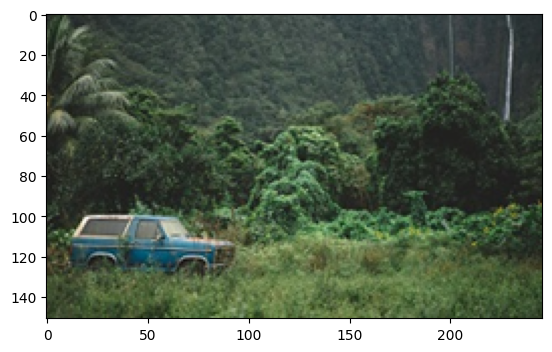

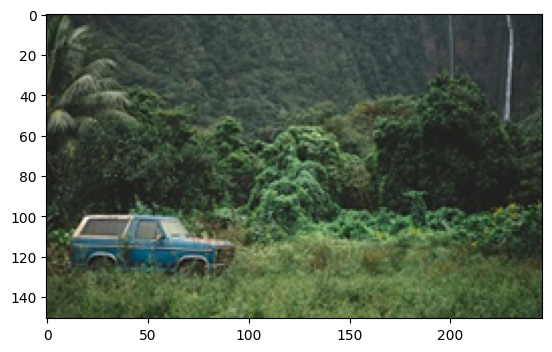

In [3]:
wm = "lab6/WM.png"
img = "lab6/InputImage.png"
secret_data = "This is a top secret message.1"

# img = "lab6/Test1.jpg"

sg = Sg(img, wm)
sg.encode(secret_data)
# sg.encode("GOD")


sg1 = Sg("lab6/EncodedImage.png", wm)
decoded_data = sg1.decode()
print("Decoded data:", decoded_data)

sg1.show()

sg.encode(decoded_data, sign=-1)

sg1 = Sg("lab6/EncodedImage.png", wm)
decoded_data = sg1.decode()
print("Decoded data:", decoded_data)

sg1.show()

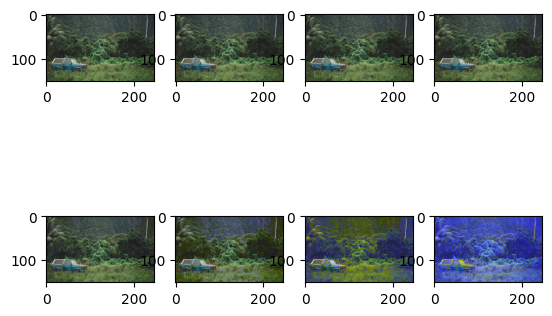

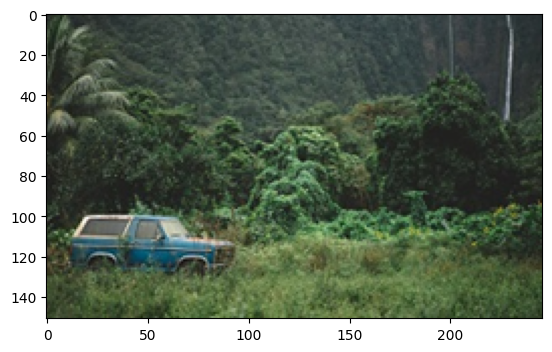

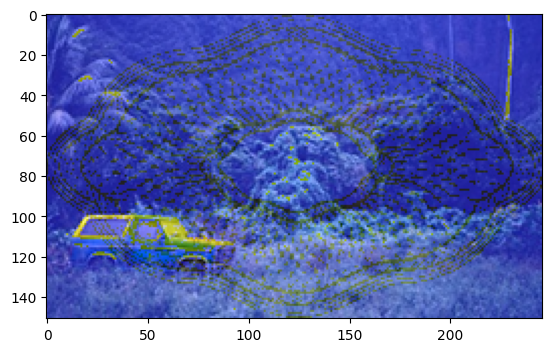

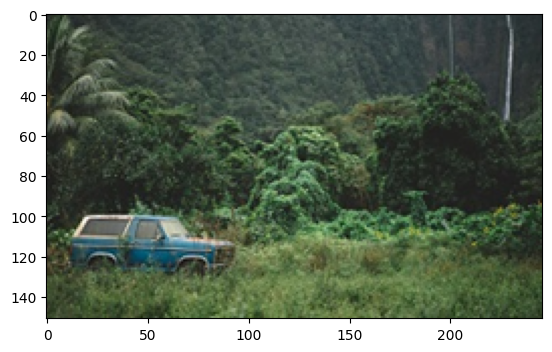

In [4]:
wm = "lab6/WM.png"
img = "lab6/InputImage.png"

sg = Sg(img, wm)
sg.show_for_all_bits_for_color(2)
# sg.show_for_all_bits_for_color(0)
# sg.show_for_all_bits_for_color(1)
# sg.show_specified_bit_for_color(7, 2)
sg.show()
sg.show(7, 2)
# sg.extract_watermark(6, 2)
sg.extract_watermark()
# sg.extract_watermark(6, 2)

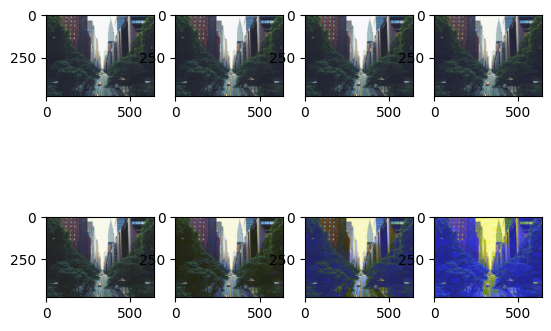

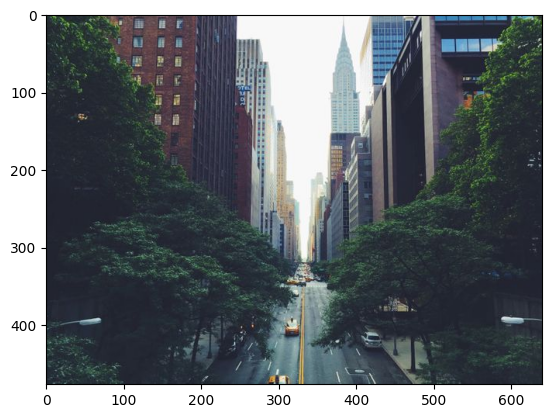

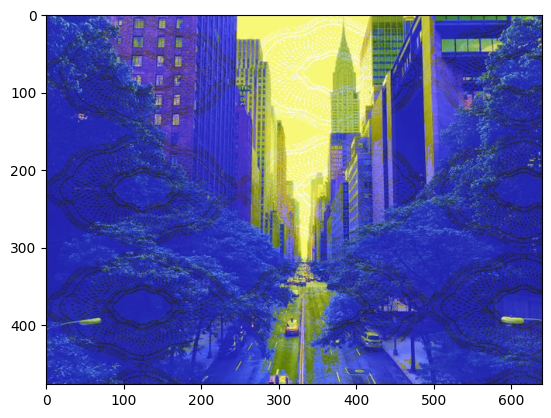

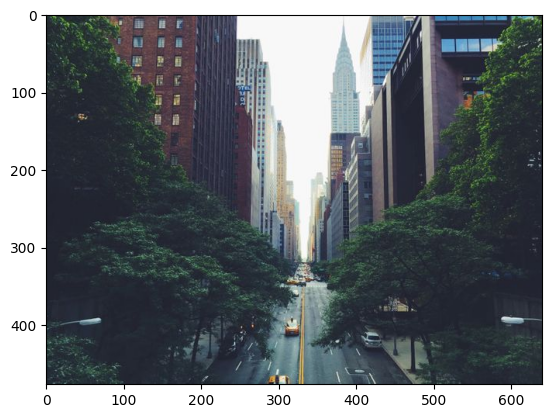

In [5]:
wm = "lab6/WM.png"
img = "lab6/Test1.jpg"

sg = Sg(img, wm)
sg.show_for_all_bits_for_color(2)
# sg.show_for_all_bits_for_color(0)
# sg.show_for_all_bits_for_color(1)
# sg.show_specified_bit_for_color(7, 2)
sg.show()
sg.show(7, 2)
# sg.extract_watermark(6, 2)
sg.extract_watermark()
# sg.extract_watermark(6, 2)


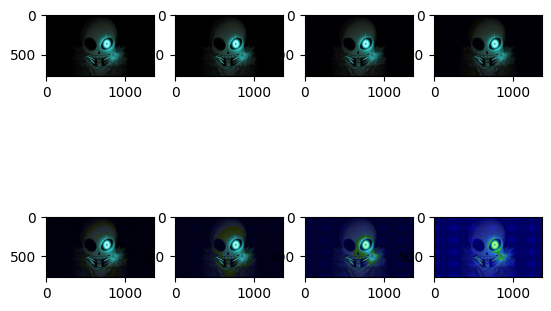

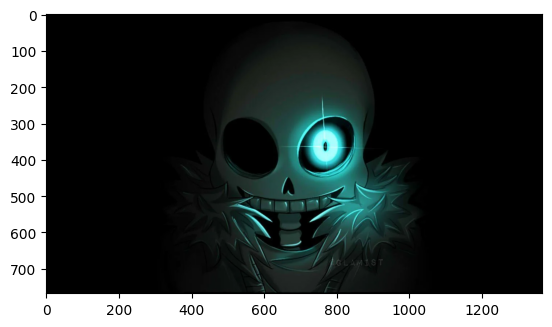

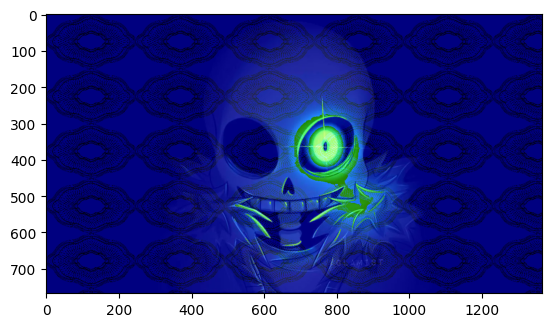

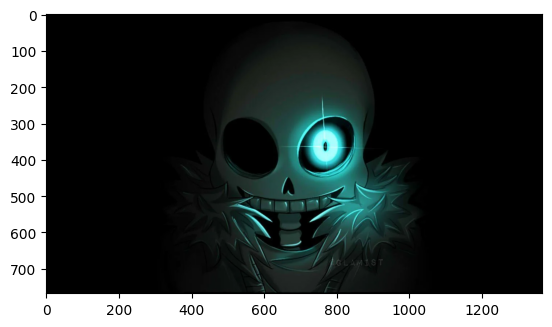

In [6]:
wm = "lab6/WM.png"
img = "lab6/test.webp"

sg = Sg(img, wm)
sg.show_for_all_bits_for_color(2)
# sg.show_for_all_bits_for_color(0)
# sg.show_for_all_bits_for_color(1)
# sg.show_specified_bit_for_color(7, 2)
sg.show()
sg.show(7, 2)
# sg.extract_watermark(6, 2)
sg.extract_watermark()
# sg.extract_watermark(6, 2)
